## Dataset generation using opencv

In [3]:
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
import keras
import keras_metrics
import matplotlib.pyplot as plt
import os 
from random import shuffle
from tqdm import tqdm

C:\Users\Marhaba\Anaconda3\envs\New_Environment_For_Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Marhaba\Anaconda3\envs\New_Environment_For_Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Marhaba\Anaconda3\envs\New_Environment_For_Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\User

In [ ]:
from numba import cuda 
device = cuda.get_current_device()
print(device)
device.reset()

In [5]:
#AlexNet Architecture for EC estimation
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(250,250,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1048, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4, activation='softmax')
])
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        3904      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)           

In [12]:
def dataset_generation():
    FaceClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    def face_detection(image):
        gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detected_face = FaceClassifier.detectMultiScale(gray_scale, 1.3, 5)
        
        if detected_face is ():
            return None
        for (x,y,w,h) in detected_face:
            face = image[y:y+h,x:x+w]
        return face
    
    videoCapture = cv2.VideoCapture(0)
    image_id = 0
    
    while True:
        ret, frame = videoCapture.read()
        if face_detection(frame) is not None:
            image_id+=1
            face = cv2.resize(face_detection(frame), (250,250))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            #Saving images from web cam to local disk
            file_name_path = "Dataset/"+"Yousaf_"+str(image_id)+'.jpg'
            cv2.imwrite(file_name_path, face)
            cv2.putText(face, str(image_id), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2 )
            
            cv2.imshow("Cropped_Face", face)
            if cv2.waitKey(1)==13 or int(image_id)==500:
                break
                
    videoCapture.release()
    cv2.destroyAllWindows()
    print("Data Collection is completed")

In [13]:
dataset_generation()

Data Collection is completed


In [7]:
import numpy as np

In [8]:
#Creating labels for each person
def label(image):
    name = image.split("_")[0]
    #One hot encoding for four persons 
    if name == "Yousaf":
        return 0
    elif name == "Qazi":
        return 1
    elif name == "Abdullah":
        return 2
    elif name == "Manzoor":
        return 3

## Preparing dataset for deep learning model

In [9]:
def load_data():
    dataset = []
    for image_name in tqdm(os.listdir("C:\\Users\\Marhaba\\Videos\\FaceID-Door-Lock-System\\Dataset")):
        image_path = os.path.join("C:\\Users\\Marhaba\\Videos\\FaceID-Door-Lock-System\\Dataset",image_name)
        image = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
        dataset.append([image,label(image_name)])
    shuffle(dataset)
    return dataset

In [10]:
dataset = load_data()

100%|██████████| 2000/2000 [00:01<00:00, 1178.54it/s]


In [12]:
dataset[1]

[array([[109, 109, 109, ..., 111, 111, 111],
        [108, 107, 106, ..., 111, 111, 111],
        [108, 106, 103, ..., 112, 112, 112],
        ...,
        [ 96,  96,  96, ...,  46,  43,  43],
        [ 96,  95,  95, ...,  44,  42,  42],
        [ 96,  95,  95, ...,  42,  43,  43]], dtype=uint8),
 1]

In [13]:
#Splitting dataset into training and testing 
train_dataset = dataset[:1600]
test_dataset = dataset[1600::]
X = np.array([k[0] for k in train_dataset]).reshape(-1,250,250,1)
print(X.shape)
Y = [j[1] for j in train_dataset]
Y = to_categorical(Y)
X_test = np.array([k[0] for k in test_dataset]).reshape(-1,250,250,1)
print(X_test.shape)
Y_test = [j[1] for j in test_dataset]
Y_test = to_categorical(Y_test)


(1600, 250, 250, 1)
(400, 250, 250, 1)


## CNN architecture for face recognition

In [12]:
print(Y[0])

[0. 0. 0. 1.]


In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])
history=model.fit(X, Y, epochs=17, batch_size=32, verbose=1, validation_split=0.3)

tracking <tf.Variable 'Variable:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_1:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_2:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_3:0' shape=() dtype=int32> fn
tracking <tf.Variable 'Variable_4:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_5:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_6:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_7:0' shape=() dtype=int32> fn

Train on 1120 samples, validate on 480 samples
Epoch 1/17
1120/1120 [==============================] - 38s 34ms/step - loss: 2.5377 - accuracy: 0.8929 - precision: 0.8483 - recall: 0.7820 - f1_score: 0.8129 - val_loss: 356.8655 - val_accuracy: 0.4062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/17
1120/1120 [==============================] - 37s 33ms/step - loss: 0.3850 - accuracy: 0.9830 - precision: 0.9697 - recall: 0.9572 - f1_score: 0.9632 - val_loss: 12

In [20]:
model.evaluate(X_test,Y_test,verbose=1)

400/400 [==============================] - 4s 9ms/step


[0.09359058469209217, 0.9900000095367432, 1.0, 1.0, 0.9999999403953552]

In [21]:
history.history.keys()


dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score', 'loss', 'accuracy', 'precision', 'recall', 'f1_score'])

dict_keys(['val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_f1_score', 'loss', 'accuracy', 'precision', 'recall', 'f1_score'])


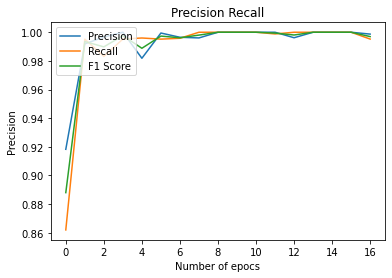

In [22]:
print(history.history.keys())
plt.plot(history.history['precision'])
plt.plot(history.history['recall'])
plt.plot(history.history['f1_score'])
plt.title('Precision Recall')
plt.ylabel('Precision')
plt.xlabel('Number of epocs')
plt.legend(['Precision', 'Recall','F1 Score'], loc='upper left')
plt.show()

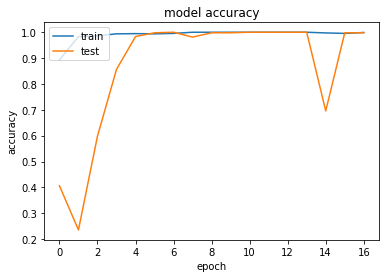

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

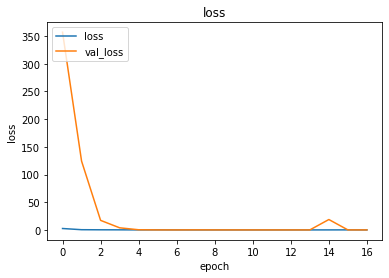

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'], loc='upper left')
plt.show()

In [16]:
# saving and loading the model weights
 
# save model
model.save_weights('faceRecognitionModel')
print('Model Saved!')
 
# load model
savedModel = model.load_weights('faceRecognitionModel')
print('Model Loaded!')

Model Saved!
Model Loaded!


In [4]:
#AlexNet Architecture for EC estimation
model2 = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(250,250,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1048, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4, activation='softmax')
])
model2.summary()
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',keras_metrics.precision(),keras_metrics.recall(),keras_metrics.f1_score()])



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 60, 32)        3904      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)           

In [5]:
# load model
savedModel = model2.load_weights('faceRecognitionModel')
print('Model Loaded!')

Model Loaded!


In [25]:
import tensorflow as tf
tf.__version__


'1.14.0'

In [14]:
model2.evaluate(X_test,Y_test,verbose=1)


400/400 [==============================] - 3s 8ms/step


[2.3136631753004622e-05, 1.0, 1.0, 1.0, 0.9999999403953552]

In [25]:
def prediction_model():
    FaceClassifier = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    def face_detection(image):
        gray_scale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        detected_face = FaceClassifier.detectMultiScale(gray_scale, 1.3, 5)
        
        if detected_face is ():
            return None
        for (x,y,w,h) in detected_face:
            face = image[y:y+h,x:x+w]
        return face
    
    videoCapture = cv2.VideoCapture(0)    
    while True:
        ret, frame = videoCapture.read()
        if face_detection(frame) is not None:
            face = cv2.resize(face_detection(frame), (250,250))
            face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
            cv2.putText(face, str("Recognising"), (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,255,0), 2 )
            cv2.imshow("Cropped_Face", face)
            prediction = model2.predict(face.reshape(-1, 250, 250, 1))
            print(prediction)
            if cv2.waitKey(1)==13:
                break
                
    videoCapture.release()
    cv2.destroyAllWindows()
    print("Data Collection is completed")

In [18]:
prediction = model2.predict(X[19].reshape(-1, 250, 250, 1))

In [19]:
print(prediction)

[[3.6272176e-18 0.0000000e+00 2.7519886e-33 1.0000000e+00]]


In [26]:
prediction_model()

[[2.02578917e-07 0.00000000e+00 1.01273556e-11 9.99999762e-01]]
[[1.6328746e-01 0.0000000e+00 6.7319073e-10 8.3671254e-01]]
[[2.7940407e-05 0.0000000e+00 8.6760449e-10 9.9997211e-01]]
[[9.91909206e-01 0.00000000e+00 1.05294535e-23 8.09084065e-03]]
[[9.9592578e-01 0.0000000e+00 6.7787890e-15 4.0742224e-03]]
[[9.9854541e-01 0.0000000e+00 2.7819863e-21 1.4545808e-03]]
[[9.9732411e-01 0.0000000e+00 4.7626160e-15 2.6758343e-03]]
[[4.3322584e-03 0.0000000e+00 6.3305357e-17 9.9566770e-01]]
[[9.970571e-01 0.000000e+00 7.557721e-14 2.942989e-03]]
[[1.3336098e-04 0.0000000e+00 2.7916855e-08 9.9986660e-01]]
[[2.8816018e-02 0.0000000e+00 2.4840624e-06 9.7118145e-01]]
[[9.6425538e-05 0.0000000e+00 4.1012338e-08 9.9990356e-01]]
[[3.0460937e-03 0.0000000e+00 3.4792625e-05 9.9691916e-01]]
[[7.1738833e-07 0.0000000e+00 1.3110036e-08 9.9999928e-01]]
[[7.0074284e-01 0.0000000e+00 1.8794687e-10 2.9925716e-01]]
[[9.9826580e-01 0.0000000e+00 1.9893173e-08 1.7341815e-03]]
[[3.2910866e-01 0.0000000e+00 6.9067

[[9.9743038e-01 0.0000000e+00 3.9353456e-08 2.5696356e-03]]
[[0.96339214 0.         0.01495648 0.02165134]]
[[9.2193857e-04 0.0000000e+00 1.9818949e-09 9.9907804e-01]]
[[3.5386602e-05 0.0000000e+00 1.0811413e-07 9.9996448e-01]]
[[3.5856836e-02 0.0000000e+00 6.7985416e-06 9.6413636e-01]]
[[0.69786406 0.         0.00122712 0.3009088 ]]
[[2.5835874e-05 0.0000000e+00 2.5534361e-11 9.9997413e-01]]
[[2.27709976e-03 0.00000000e+00 1.21411475e-11 9.97722924e-01]]
[[2.3453495e-06 0.0000000e+00 1.7366083e-09 9.9999762e-01]]
[[7.8491715e-04 0.0000000e+00 6.2728660e-08 9.9921501e-01]]
[[2.6540768e-08 0.0000000e+00 9.3229868e-11 1.0000000e+00]]
[[7.9937028e-03 0.0000000e+00 9.9254452e-11 9.9200636e-01]]
[[3.1162331e-06 0.0000000e+00 6.1409176e-12 9.9999690e-01]]
[[6.20992922e-14 0.00000000e+00 1.13567857e-10 1.00000000e+00]]
[[2.4757509e-07 0.0000000e+00 3.5596482e-13 9.9999976e-01]]
[[3.6948515e-04 0.0000000e+00 6.0222938e-14 9.9963045e-01]]
[[1.3539311e-06 0.0000000e+00 1.3732471e-10 9.9999869e-0

[[1.5043344e-10 0.0000000e+00 6.5475625e-08 9.9999988e-01]]
[[1.4646185e-09 0.0000000e+00 1.1399719e-09 1.0000000e+00]]
[[2.4595425e-07 0.0000000e+00 2.1313305e-04 9.9978667e-01]]
[[4.5318965e-10 0.0000000e+00 4.8085531e-06 9.9999523e-01]]
[[3.0964369e-09 0.0000000e+00 9.0106111e-14 1.0000000e+00]]
[[5.583289e-04 0.000000e+00 8.045039e-05 9.993612e-01]]
[[7.4496875e-06 0.0000000e+00 1.5349681e-10 9.9999261e-01]]
[[4.3867923e-10 0.0000000e+00 4.3799076e-08 1.0000000e+00]]
[[4.5959382e-06 0.0000000e+00 3.1463867e-07 9.9999511e-01]]
[[5.1410216e-32 0.0000000e+00 8.1139470e-18 1.0000000e+00]]
[[9.7724076e-32 0.0000000e+00 1.2471796e-18 1.0000000e+00]]
[[6.3724104e-31 0.0000000e+00 5.9417474e-19 1.0000000e+00]]
[[3.1841781e-25 0.0000000e+00 2.2384355e-10 1.0000000e+00]]
[[8.285024e-28 0.000000e+00 2.892855e-16 1.000000e+00]]
[[8.162678e-28 0.000000e+00 6.553199e-19 1.000000e+00]]
[[4.047452e-28 0.000000e+00 3.835586e-15 1.000000e+00]]
[[4.2986259e-27 0.0000000e+00 3.7809502e-22 1.0000000e+0

[[3.7735337e-10 0.0000000e+00 9.9998355e-01 1.6455922e-05]]
[[2.2796391e-06 0.0000000e+00 9.7564131e-01 2.4356317e-02]]
[[3.0032312e-14 0.0000000e+00 9.9972218e-01 2.7783806e-04]]
[[4.2736357e-08 0.0000000e+00 9.9743807e-01 2.5618940e-03]]
[[3.968761e-09 0.000000e+00 5.000162e-01 4.999838e-01]]
[[2.0083269e-06 0.0000000e+00 4.0036738e-03 9.9599433e-01]]
[[9.0691632e-09 0.0000000e+00 9.9999714e-01 2.8541185e-06]]
[[5.5776956e-09 0.0000000e+00 9.9997306e-01 2.6980877e-05]]
[[4.1734373e-11 0.0000000e+00 9.7576833e-01 2.4231682e-02]]
[[4.2892033e-08 0.0000000e+00 3.5176487e-03 9.9648225e-01]]
[[9.5583482e-06 0.0000000e+00 2.4247228e-01 7.5751817e-01]]
[[5.1635883e-12 0.0000000e+00 1.0000000e+00 4.1936463e-08]]
[[6.1690841e-10 0.0000000e+00 9.9997354e-01 2.6425445e-05]]
[[2.4351559e-09 0.0000000e+00 9.9994731e-01 5.2677635e-05]]
[[7.0486911e-10 0.0000000e+00 9.9999666e-01 3.3057543e-06]]
[[3.5554034e-08 0.0000000e+00 9.5766857e-02 9.0423316e-01]]
[[1.0278188e-07 0.0000000e+00 9.9803692e-01 

[[9.9999177e-01 0.0000000e+00 2.3805411e-08 8.2647830e-06]]
[[7.1981865e-01 0.0000000e+00 3.5078279e-05 2.8014627e-01]]
[[9.9949968e-01 0.0000000e+00 3.7179976e-05 4.6312663e-04]]
[[9.9999988e-01 0.0000000e+00 1.9678095e-09 1.0462795e-07]]
[[9.999168e-01 0.000000e+00 3.809541e-06 7.933987e-05]]
[[9.9805272e-01 0.0000000e+00 8.7720260e-08 1.9471395e-03]]
[[0.00710338 0.         0.06988297 0.9230136 ]]
[[9.6854615e-01 0.0000000e+00 1.9223171e-06 3.1451870e-02]]
[[9.9998140e-01 0.0000000e+00 2.4642771e-10 1.8594257e-05]]
[[4.5244672e-04 0.0000000e+00 1.8418727e-06 9.9954563e-01]]
[[1.9006601e-04 0.0000000e+00 9.4606109e-02 9.0520382e-01]]
[[9.2049187e-01 0.0000000e+00 1.2594638e-05 7.9495534e-02]]
[[9.9999440e-01 0.0000000e+00 2.1403962e-06 3.4723446e-06]]
[[0.00068714 0.         0.42731485 0.57199806]]
[[0.8021464  0.         0.00100531 0.19684832]]
[[0.010263   0.         0.805633   0.18410398]]
[[1.3496100e-03 0.0000000e+00 4.4553635e-05 9.9860591e-01]]
[[1.0000000e+00 0.0000000e+00 3.

[[1.7661785e-06 0.0000000e+00 2.4203709e-04 9.9975616e-01]]
[[2.5649732e-07 0.0000000e+00 2.5929778e-10 9.9999976e-01]]
[[2.0703567e-10 0.0000000e+00 3.7349958e-12 1.0000000e+00]]
[[3.3022375e-06 0.0000000e+00 1.2240724e-07 9.9999654e-01]]
[[3.7459948e-04 0.0000000e+00 8.1859845e-08 9.9962533e-01]]
[[2.4544887e-08 0.0000000e+00 1.2427738e-12 1.0000000e+00]]
[[8.8929283e-07 0.0000000e+00 8.0286561e-10 9.9999917e-01]]
[[5.9425447e-04 0.0000000e+00 2.0714350e-15 9.9940574e-01]]
[[4.2155560e-04 0.0000000e+00 2.3850104e-15 9.9957842e-01]]
[[4.679511e-08 0.000000e+00 1.781775e-11 1.000000e+00]]
[[1.84489368e-10 0.00000000e+00 1.05939774e-16 1.00000000e+00]]
[[5.095295e-10 0.000000e+00 9.750718e-13 1.000000e+00]]
[[2.0093728e-07 0.0000000e+00 7.9978587e-15 9.9999976e-01]]
[[3.8321630e-07 0.0000000e+00 2.3387950e-11 9.9999964e-01]]
[[5.874923e-11 0.000000e+00 5.909375e-20 1.000000e+00]]
[[9.6341832e-12 0.0000000e+00 1.6837977e-18 1.0000000e+00]]
[[2.4487190e-07 0.0000000e+00 7.2910698e-11 9.99

[[1.7865162e-10 0.0000000e+00 7.5274635e-08 9.9999988e-01]]
[[3.9410529e-07 0.0000000e+00 3.8617608e-07 9.9999917e-01]]
[[2.4708148e-08 0.0000000e+00 3.2934275e-07 9.9999964e-01]]
[[2.7013684e-12 0.0000000e+00 3.7657199e-07 9.9999964e-01]]
[[1.17979125e-05 0.00000000e+00 2.06695754e-11 9.99988198e-01]]
[[1.1697967e-07 0.0000000e+00 6.2755277e-09 9.9999988e-01]]
[[3.6892380e-15 0.0000000e+00 1.2098601e-10 1.0000000e+00]]
[[2.3996878e-01 0.0000000e+00 6.6417429e-05 7.5996482e-01]]
[[9.3353850e-01 0.0000000e+00 1.6047725e-05 6.6445440e-02]]
[[4.3335868e-04 0.0000000e+00 8.7854652e-08 9.9956650e-01]]
[[7.0609917e-06 0.0000000e+00 9.9373561e-01 6.2573482e-03]]
[[0.7964993  0.         0.00143544 0.20206529]]
[[1.0077202e-07 0.0000000e+00 5.2787446e-08 9.9999988e-01]]
[[2.9061322e-05 0.0000000e+00 5.8915921e-05 9.9991202e-01]]
[[2.0775733e-05 0.0000000e+00 1.1858910e-03 9.9879336e-01]]
[[0.06675461 0.         0.33708772 0.5961576 ]]
[[2.2625186e-06 0.0000000e+00 6.3489733e-06 9.9999142e-01]]


[[1.8690508e-06 0.0000000e+00 6.2201339e-05 9.9993598e-01]]
[[5.6931093e-10 0.0000000e+00 1.9738552e-08 1.0000000e+00]]
[[2.8512085e-11 0.0000000e+00 6.6576573e-14 1.0000000e+00]]
[[3.2448344e-09 0.0000000e+00 6.1564078e-04 9.9938428e-01]]
[[1.8361577e-12 0.0000000e+00 1.8201763e-09 1.0000000e+00]]
[[2.1934431e-08 0.0000000e+00 9.8025069e-08 9.9999988e-01]]
[[3.969077e-04 0.000000e+00 9.896582e-01 9.944899e-03]]
[[0.2534977  0.         0.72854215 0.01796011]]
[[8.385264e-12 0.000000e+00 5.387766e-09 1.000000e+00]]
[[3.6305220e-05 0.0000000e+00 9.9909616e-01 8.6748064e-04]]
[[8.4620604e-09 0.0000000e+00 2.1580444e-09 1.0000000e+00]]
[[6.6008887e-12 0.0000000e+00 1.1953340e-05 9.9998808e-01]]
[[1.02738404e-07 0.00000000e+00 2.38438536e-09 9.99999881e-01]]
[[0.01463735 0.         0.55101085 0.43435174]]
[[2.4911056e-05 0.0000000e+00 1.7948208e-08 9.9997509e-01]]
[[1.3468074e-08 0.0000000e+00 1.1754585e-13 1.0000000e+00]]
[[1.46009819e-11 0.00000000e+00 1.17200425e-05 9.99988317e-01]]
[[1.

[[2.9765566e-37 0.0000000e+00 2.7716349e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.7545775e-06 9.9999821e-01]]
[[0.0000000e+00 0.0000000e+00 3.3708730e-07 9.9999964e-01]]
[[0.0000000e+00 0.0000000e+00 1.4323712e-11 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.343183e-11 1.000000e+00]]
[[0.00000e+00 0.00000e+00 6.91296e-10 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2947753e-11 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0588008e-12 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.244942e-15 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.1113405e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.1731015e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.6766302e-14 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.964993e-12 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2769141e-14 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0315837e-12 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.947195e-13 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8194498e-14 1.0000000e+00]]
[[0.

[[0.0000000e+00 0.0000000e+00 3.2570693e-08 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6635864e-08 1.0000000e+00]]
[[0.         0.         0.00454668 0.99545336]]
[[0.0000000e+00 0.0000000e+00 2.7506019e-06 9.9999726e-01]]
[[0.0000000e+00 0.0000000e+00 3.4104344e-10 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.3803721e-08 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.809360e-07 9.999995e-01]]
[[0.0000000e+00 0.0000000e+00 1.8459168e-07 9.9999976e-01]]
[[0.000000e+00 0.000000e+00 9.068872e-04 9.990932e-01]]
[[0.0000000e+00 0.0000000e+00 9.1536320e-05 9.9990845e-01]]
[[0.0000000e+00 0.0000000e+00 5.2929202e-08 1.0000000e+00]]
[[0.         0.         0.00411617 0.99588376]]
[[0.0000000e+00 0.0000000e+00 3.8449944e-05 9.9996150e-01]]
[[0.0000000e+00 0.0000000e+00 1.5301574e-05 9.9998474e-01]]
[[0.0000000e+00 0.0000000e+00 2.9057239e-06 9.9999714e-01]]
[[0.         0.         0.00894374 0.9910562 ]]
[[0.0000000e+00 0.0000000e+00 2.8233053e-04 9.9971765e-01]]
[[0.0000000e+00 0.000000

[[0.0000000e+00 0.0000000e+00 1.4357622e-27 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.917462e-22 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.8836046e-29 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.5338375e-25 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.951212e-24 1.000000e+00]]
[[0.000000e+00 0.000000e+00 1.974422e-21 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.6001365e-27 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.2873634e-25 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.461737e-23 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.1517907e-27 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.7085157e-31 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9703186e-24 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.8705157e-25 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 8.1055034e-25 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.391464e-25 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.745601e-25 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.7855625e-25 1.0000000e+00]]
[[0.

[[0.0000000e+00 0.0000000e+00 3.1539117e-30 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3459708e-30 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.5629721e-25 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 3.28739e-30 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 1.3511437e-33 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0922106e-28 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3800835e-27 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.285126e-27 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.2854003e-24 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4724973e-28 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.9851794e-25 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.9201067e-24 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 3.561026e-25 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.931341e-24 1.000000e+00]]
[[0.000000e+00 0.000000e+00 2.294425e-23 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.1639728e-23 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0733073e-20 1.0000000e+00]]
[[0.

[[0.0000000e+00 0.0000000e+00 1.1367483e-34 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.810347e-35 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.3641494e-36 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.0340247e-35 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.2344754e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.4812067e-29 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.141765e-28 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.2100104e-31 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.7418617e-31 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9349848e-29 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4342341e-32 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.5800724e-30 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 2.321583e-33 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.7513106e-30 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 6.47473e-33 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 2.9724097e-33 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.911963e-31 1.000000e+00]]
[[0.

[[0.000000e+00 0.000000e+00 8.808567e-36 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4362568e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.6057153e-36 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2414532e-36 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 2.956069e-34 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2116724e-37 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.588768e-36 1.000000e+00]]
[[0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 1.3493793e-37 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 2.934894e-38 1.000000e+00]]
[[0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 8.5753446e-38 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8715053e-38 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.3108483e-37 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.9139775e-36 1.0000000e+00]]
[[0. 0. 0. 1.]]
[[0.000000e+00 0.000000e+00 4.941891e-37 1.000000e+00]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 1.9315026e-38 1.0000000e+00]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0.0000

[[0.0000000e+00 0.0000000e+00 2.1354398e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.4537014e-34 1.0000000e+00]]
[[0. 0. 0. 1.]]
[[0.000000e+00 0.000000e+00 1.927345e-37 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.8178185e-31 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.185911e-29 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4401743e-25 1.0000000e+00]]
[[2.4153756e-38 0.0000000e+00 8.0473732e-31 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.4970737e-35 1.0000000e+00]]
[[3.4463428e-35 0.0000000e+00 1.5987694e-38 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 4.62155e-32 1.00000e+00]]
[[0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 2.3018526e-36 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2711469e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8500195e-30 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.4865264e-38 1.0000000e+00]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 2.0278385e-37 1.00

[[0.000000e+00 0.000000e+00 1.000000e+00 5.506002e-27]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 3.0455672e-27]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 5.1694226e-23]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 7.7088525e-31]]
[[0.000000e+00 0.000000e+00 1.000000e+00 1.161867e-15]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 1.7490546e-28]]
[[0.000000e+00 0.000000e+00 1.000000e+00 7.761612e-31]]
[[0.000000e+00 0.000000e+00 1.000000e+00 7.826265e-34]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 8.2589704e-33]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 4.0004118e-32]]
[[0.000000e+00 0.000000e+00 1.000000e+00 1.449852e-27]]
[[0.000000e+00 0.000000e+00 1.000000e+00 2.580755e-30]]
[[0.000000e+00 0.000000e+00 1.000000e+00 6.878208e-26]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 2.1641279e-32]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 1.7776893e-21]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 3.1097776e-24]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 1.6065602e-28]]
[[0.0000

[[0.         0.         0.89431304 0.10568696]]
[[0.         0.         0.5489795  0.45102045]]
[[0.         0.         0.00240219 0.99759775]]
[[0.0000000e+00 0.0000000e+00 1.2200275e-04 9.9987793e-01]]
[[0.         0.         0.00145085 0.99854916]]
[[0.         0.         0.06226106 0.9377389 ]]
[[0.000000e+00 0.000000e+00 8.173914e-05 9.999182e-01]]
[[0.         0.         0.0013432  0.99865675]]
[[0.         0.         0.20351577 0.79648423]]
[[0.0000000e+00 0.0000000e+00 1.0671189e-04 9.9989331e-01]]
[[0.000000e+00 0.000000e+00 5.027017e-05 9.999497e-01]]
[[0.0000000e+00 0.0000000e+00 1.4188522e-05 9.9998581e-01]]
[[0.         0.         0.00349271 0.9965072 ]]
[[0.         0.         0.04250712 0.95749295]]
[[0.000000e+00 0.000000e+00 3.162659e-05 9.999684e-01]]
[[0.0000000e+00 0.0000000e+00 1.2626574e-06 9.9999869e-01]]
[[0.         0.         0.01615659 0.9838434 ]]
[[0.         0.         0.00737515 0.9926248 ]]
[[0.0000000e+00 0.0000000e+00 2.4489645e-04 9.9975508e-01]]
[[0.

[[0.0000000e+00 0.0000000e+00 2.9520683e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8151249e-28 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.8053326e-20 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.726898e-21 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.9767104e-18 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.803665e-20 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4398988e-22 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 9.7909976e-23 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.281682e-29 1.000000e+00]]
[[0.000000e+00 0.000000e+00 1.530944e-22 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.3477324e-21 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1121408e-19 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 3.34222e-21 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 6.4290196e-20 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.4696986e-19 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.945785e-20 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.3292417e-28 1.0000000e+00]]
[[0.0000

[[0.0000000e+00 0.0000000e+00 1.2158526e-06 9.9999881e-01]]
[[0.0000000e+00 0.0000000e+00 2.6667074e-06 9.9999738e-01]]
[[0.         0.         0.9912634  0.00873665]]
[[0.         0.         0.97847307 0.02152693]]
[[0.0000000e+00 0.0000000e+00 9.9999917e-01 8.3720624e-07]]
[[0.0000000e+00 0.0000000e+00 9.9999750e-01 2.5543059e-06]]
[[0.0000000e+00 0.0000000e+00 9.9999988e-01 1.2569683e-07]]
[[0.         0.         0.9982047  0.00179527]]
[[0.         0.         0.00547534 0.9945247 ]]
[[0.0000000e+00 0.0000000e+00 9.9936193e-01 6.3809066e-04]]
[[0.         0.         0.36576456 0.6342354 ]]
[[0.0000000e+00 0.0000000e+00 9.9964023e-01 3.5972273e-04]]
[[0.0000000e+00 0.0000000e+00 1.0000000e+00 1.2912695e-09]]
[[0.        0.        0.9966628 0.0033372]]
[[0.0000000e+00 0.0000000e+00 7.3822886e-09 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.8543886e-10 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1702994e-10 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8321872e-08 1.0000000e+0

[[1.2567219e-10 0.0000000e+00 1.9918052e-22 1.0000000e+00]]
[[6.036501e-07 0.000000e+00 6.161899e-16 9.999994e-01]]
[[6.3709198e-11 0.0000000e+00 1.5481387e-23 1.0000000e+00]]
[[4.5682000e-06 0.0000000e+00 3.1813147e-15 9.9999547e-01]]
[[2.9206260e-12 0.0000000e+00 4.3049377e-11 1.0000000e+00]]
[[7.8802994e-05 0.0000000e+00 3.9887204e-06 9.9991715e-01]]
[[1.4324156e-10 0.0000000e+00 9.1834554e-11 1.0000000e+00]]
[[4.7182317e-14 0.0000000e+00 5.2303499e-26 1.0000000e+00]]
[[2.637308e-12 0.000000e+00 9.798727e-24 1.000000e+00]]
[[1.5167753e-10 0.0000000e+00 6.0848868e-13 1.0000000e+00]]
[[8.3570386e-09 0.0000000e+00 1.0390402e-06 9.9999893e-01]]
[[4.5293268e-06 0.0000000e+00 9.9870396e-01 1.2915151e-03]]
[[8.2265812e-11 0.0000000e+00 2.0880946e-11 1.0000000e+00]]
[[3.2230874e-11 0.0000000e+00 1.7980023e-14 1.0000000e+00]]
[[4.1232130e-13 0.0000000e+00 1.6643612e-15 1.0000000e+00]]
[[2.2934466e-14 0.0000000e+00 1.2196810e-15 1.0000000e+00]]
[[4.954027e-11 0.000000e+00 1.200058e-10 1.00000

[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0.00000e+00 0.00000e+00 2.62647e-38 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 2.7846137e-37 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.5049984e-35 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0927629e-33 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 2.275759e-33 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8711969e-32 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.4091217e-32 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.097497e-33 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0533122e-33 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.8163686e-25 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.1988763e-38 1.0000000e+00]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0.000000e+00 0.000000e+00 5.265916e-37 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0138127e-33 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.7997627e-35 1.00

[[0.0000000e+00 0.0000000e+00 4.4421386e-35 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.857562e-33 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.976085e-36 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.1165625e-33 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.1425037e-36 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.0748784e-33 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6536436e-34 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.657655e-33 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.836245e-33 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4391978e-32 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.630641e-31 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.885641e-32 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.6185302e-28 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.853014e-29 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.4097368e-36 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.5235756e-35 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 5.287028e-38 1.000000e+00]]
[[0. 0. 0. 1

[[0.000000e+00 0.000000e+00 4.016074e-22 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3635167e-20 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.259274e-23 1.000000e+00]]
[[0.000000e+00 0.000000e+00 2.569363e-28 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3696742e-27 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9034342e-26 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0938403e-23 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8122038e-22 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.691108e-23 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.622844e-25 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.8897603e-25 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.688026e-22 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.9039181e-22 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.158448e-21 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.7196764e-17 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 2.865362e-18 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3695472e-20 1.0000000e+00]]
[[0.0000000e

[[0.000000e+00 0.000000e+00 6.982629e-20 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.3761256e-19 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 3.18675e-20 1.00000e+00]]
[[0.000000e+00 0.000000e+00 5.997942e-22 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.224411e-26 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0651338e-26 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1989563e-27 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 3.44801e-29 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 6.3996865e-26 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 8.0222606e-26 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.1720135e-21 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.126351e-21 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2029377e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0420292e-19 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.012853e-20 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.5147278e-15 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.856275e-13 1.000000e+00]]
[[0.0000000e+00 0.00

[[0.0000000e+00 0.0000000e+00 1.4018053e-30 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.516726e-29 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.1965696e-33 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 1.25408e-30 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0693013e-30 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.2748076e-35 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.5380284e-31 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 8.06642e-33 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9491289e-35 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.1598864e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8708766e-31 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.1857118e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.7238247e-30 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.5038616e-32 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 1.11716e-31 1.00000e+00]]
[[0.000000e+00 0.000000e+00 2.861007e-31 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 8.1910896e-29 1.0000000e+00]]
[[0.0000000e

[[0.000000e+00 0.000000e+00 3.119534e-38 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.0893492e-37 1.0000000e+00]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0.000000e+00 0.000000e+00 7.532298e-36 1.000000e+00]]
[[0.000000e+00 0.000000e+00 1.876131e-37 1.000000e+00]]
[[0. 0. 0. 1.]]
[[0.000000e+00 0.000000e+00 7.596929e-38 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.3030497e-34 1.0000000e+00]]
[[0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 3.4822234e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.2130032e-37 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.5173277e-37 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 3.483654e-29 1.000000e+00]]
[[0.000000e+00 0.000000e+00 5.345187e-31 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.2467805e-29 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.699319e-30 1.000000e+00]]
[[0.000000e+00 0.000000e+00 8.129047e-30 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.3088477e-30 1.0000000e+00]]
[[0.

[[0.0000000e+00 0.0000000e+00 4.2549327e-21 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.0674756e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.1688698e-20 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.5048762e-22 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4213733e-22 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.417408e-23 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.7415419e-18 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.9842796e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0817942e-16 1.0000000e+00]]
[[0.0000e+00 0.0000e+00 5.9242e-14 1.0000e+00]]
[[0.0000000e+00 0.0000000e+00 6.1655613e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9093406e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1184009e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.7334114e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.8941678e-24 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0280266e-23 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.7876676e-26 1.0000000e+0

[[0.000000e+00 0.000000e+00 2.516081e-23 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8227402e-24 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.6759238e-23 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6919263e-22 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.1756637e-25 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.6991856e-24 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.6557944e-24 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.398931e-24 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 9.7214614e-26 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6368712e-22 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.7230877e-24 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9759678e-20 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4122988e-24 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.063912e-22 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.6558773e-25 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.1060565e-23 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.059738e-24 1.000000e+0

[[0.0000000e+00 0.0000000e+00 3.9271803e-19 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.325132e-16 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.1394394e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9714853e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.4204323e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.3533033e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0263273e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.1146143e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8522177e-13 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 3.744777e-15 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.3654726e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2325802e-16 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 2.285911e-12 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.2757966e-17 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 1.37623e-14 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0804942e-14 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0237724e-16 1.0000000e+00]]


[[0.00000e+00 0.00000e+00 5.20663e-15 1.00000e+00]]
[[0.000000e+00 0.000000e+00 5.667888e-17 1.000000e+00]]
[[0.000000e+00 0.000000e+00 8.200653e-15 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.8231614e-14 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.8552343e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0232263e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.4947093e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.6609533e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2904813e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.2817234e-21 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.3281647e-18 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 6.206743e-18 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.802827e-19 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.3515147e-21 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6073408e-18 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3686044e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6583225e-14 1.0000000e+00]]
[[0.

[[0.0000000e+00 0.0000000e+00 9.6389084e-23 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.7373376e-17 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.952501e-22 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.0880607e-19 1.0000000e+00]]
[[0.00000000e+00 0.00000000e+00 1.01022545e-23 1.00000000e+00]]
[[0.000000e+00 0.000000e+00 1.604453e-21 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.4078377e-19 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.511156e-20 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 8.1537746e-21 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.518583e-19 1.000000e+00]]
[[0.000000e+00 0.000000e+00 3.999302e-15 1.000000e+00]]
[[0.00000e+00 0.00000e+00 5.57641e-20 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 2.2037829e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.4874793e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.1806235e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2416939e-15 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.860514e-18 1.000000e+00]]
[[0.0000

[[0.000000e+00 0.000000e+00 1.171615e-36 1.000000e+00]]
[[0.000000e+00 0.000000e+00 3.866664e-34 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9010038e-33 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 3.176976e-37 1.000000e+00]]
[[0. 0. 0. 1.]]
[[0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 8.1755184e-35 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1310991e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.0234238e-34 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 5.007365e-35 1.000000e+00]]
[[0.00000000e+00 0.00000000e+00 1.13713366e-35 1.00000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6079508e-37 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0184227e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.3340103e-36 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3736998e-35 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0544451e-34 1.0000000e+00]]
[[0. 0. 0. 1.]]
[[0.0000000e+00 0.0000000e+00 1.5391489e-28 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 8.8358274e-36 1.0000000e+00]]
[[0.

[[0.0000000e+00 0.0000000e+00 1.1527742e-27 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.9204288e-27 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.1266296e-26 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8087934e-28 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.537086e-25 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 9.2234615e-26 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.5482124e-27 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.6911315e-26 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6991874e-25 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 3.577019e-20 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0019993e-18 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.223945e-16 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.7153897e-19 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.726856e-16 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.7713423e-18 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.3688523e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0270605e-19 1.0000000e+0

[[0.0000000e+00 0.0000000e+00 1.2183965e-09 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8134754e-08 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.9042984e-09 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3156511e-08 1.0000000e+00]]
[[4.654464e-37 0.000000e+00 6.948096e-10 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4209564e-08 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.366459e-09 1.000000e+00]]
[[0.000000e+00 0.000000e+00 1.057814e-10 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.3731809e-12 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.011552e-08 1.000000e+00]]
[[0.00000e+00 0.00000e+00 5.57787e-08 1.00000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0394798e-10 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8231501e-06 9.9999821e-01]]
[[3.356898e-38 0.000000e+00 3.958785e-10 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.5811566e-09 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.5358207e-11 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.222871e-07 9.999993e-01]]
[[1.2109568e

[[0.0000000e+00 0.0000000e+00 3.8324774e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.1801034e-15 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.659628e-18 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8189543e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2680596e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.7515593e-20 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 5.748883e-20 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9817444e-18 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.5924733e-16 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.265337e-18 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.122208e-16 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2322819e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.9028955e-17 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 5.396754e-17 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.3984896e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.5780673e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.3284147e-16 1.0000000e+00]]


[[0.0000000e+00 0.0000000e+00 1.0020916e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6991052e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.6139313e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 9.1425695e-20 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 3.007089e-20 1.000000e+00]]
[[0.000000e+00 0.000000e+00 6.916803e-20 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2404096e-17 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.329938e-17 1.000000e+00]]
[[0.000000e+00 0.000000e+00 9.515735e-19 1.000000e+00]]
[[0.000000e+00 0.000000e+00 8.711102e-19 1.000000e+00]]
[[0.000000e+00 0.000000e+00 6.415974e-16 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.6427007e-21 1.0000000e+00]]
[[0.00000000e+00 0.00000000e+00 1.05623924e-14 1.00000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.7716809e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.4817028e-13 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.118827e-17 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.8840268e-15 1.0000000e+00]]
[[0.

[[0.0000000e+00 0.0000000e+00 1.6115796e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.6613084e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0484868e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1709133e-14 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0885967e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1357034e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.4392436e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.9309736e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.6279582e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.7477717e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.0370127e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0554255e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.5855423e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.2193683e-14 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1516448e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.2135479e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.6746482e

[[0.0000000e+00 0.0000000e+00 2.4788952e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.4846055e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4586512e-14 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.1349252e-14 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.6119434e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.0840012e-16 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 6.24532e-16 1.00000e+00]]
[[0.000000e+00 0.000000e+00 2.833563e-14 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.7513884e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.5869281e-14 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.453116e-16 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.3801152e-14 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 9.1861875e-15 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 1.625731e-16 1.000000e+00]]
[[0.000000e+00 0.000000e+00 2.421353e-16 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.7495917e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.5110195e-15 1.0000000e+00]]
[[0.

[[0.00000e+00 0.00000e+00 6.19007e-19 1.00000e+00]]
[[0.000000e+00 0.000000e+00 4.502998e-19 1.000000e+00]]
[[0.000000e+00 0.000000e+00 7.882847e-16 1.000000e+00]]
[[0.000000e+00 0.000000e+00 8.388315e-13 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.5809196e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.4395846e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9528009e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.8092317e-18 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 8.2021956e-20 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.614703e-20 1.000000e+00]]
[[0.000000e+00 0.000000e+00 8.714351e-21 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.9321003e-19 1.0000000e+00]]
[[0.0000e+00 0.0000e+00 4.8222e-16 1.0000e+00]]
[[0.0000000e+00 0.0000000e+00 5.4858823e-17 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.5792855e-18 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.946899e-18 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.1123268e-17 1.0000000e+00]]
[[0.0000000e+00 0.000000

[[0.000000e+00 0.000000e+00 9.693846e-09 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.0647259e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 7.0563495e-19 1.0000000e+00]]
[[0.00000e+00 0.00000e+00 7.48913e-26 1.00000e+00]]
[[0.000000e+00 0.000000e+00 3.960398e-19 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.3210356e-19 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9118405e-17 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 4.421622e-09 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4266946e-11 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.0103403e-11 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.8332965e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 8.0353915e-13 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2811534e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.8575167e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.0002494e-12 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.576522e-17 1.000000e+00]]
[[0.000000e+00 0.000000e+00 2.941035e-16 1.000000e+00]]
[[0.0000

[[0.0000000e+00 0.0000000e+00 2.0351215e-16 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 4.9832913e-15 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 9.937223e-15 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.1129633e-10 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 8.6377234e-08 9.9999988e-01]]
[[0.0000000e+00 0.0000000e+00 4.3089855e-12 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.1001539e-10 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 2.718093e-09 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.9440384e-11 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.3558033e-15 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 8.285349e-11 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.2636066e-15 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.7506023e-14 1.0000000e+00]]
[[1.8062468e-38 0.0000000e+00 3.4468624e-16 1.0000000e+00]]
[[3.0277934e-37 0.0000000e+00 5.7688862e-16 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 7.723022e-13 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9460665e-14 1.0000000e+0

[[0.0000000e+00 0.0000000e+00 2.0632324e-37 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.2319694e-38 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.2212449e-38 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 5.0310736e-33 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 3.029249e-37 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.5579747e-38 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 1.9784103e-36 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.0916296e-34 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 6.7528267e-31 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 2.464633e-29 1.000000e+00]]
[[0.000000e+00 0.000000e+00 4.022543e-30 1.000000e+00]]
[[0.000000e+00 0.000000e+00 3.095773e-33 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.1493258e-33 1.0000000e+00]]
[[0.000000e+00 0.000000e+00 5.041712e-35 1.000000e+00]]
[[0.000000e+00 0.000000e+00 5.245522e-31 1.000000e+00]]
[[0.0000000e+00 0.0000000e+00 2.4705932e-35 1.0000000e+00]]
[[0.0000000e+00 0.0000000e+00 3.4935557e-36 1.0000000e+00]]
[[0.